# Hierarchical model fit on data of Darmanis *et al.* (2015)

In [4]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
from scipy.stats import norm
import itertools
from sklearn.cluster import KMeans
from sklearn import datasets
import os
import pickle
import scipy
from utils import loadStan, hierarchical_model, est_k
sns.set()
from sklearn.metrics import adjusted_rand_score
import pyreadr
import csv
import math
import time

ppca_model = loadStan('ppca')
gmm_model = loadStan('gmm')
moppcas_model = loadStan('moppcas')
moppcas_weighted = loadStan('moppcas_weighted')
ppca_weighted = loadStan('ppca_weighted')
gmm_weighted = loadStan('gmm_weighted')

Loading model  ppca
Model loaded succesfully from cache.
Loading model  gmm
Model loaded succesfully from cache.
Loading model  moppcas
Model loaded succesfully from cache.
Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Loading model  gmm_weighted
Model loaded succesfully from cache.


## Loading data
Data used from Darmanis *et al.* (2015), containing 465 samples including 22088 genes, from 9 different celltypes.

In [2]:
celltype_dict = {}
with open('../DataSets/Darmanis/GSE67835_family.soft') as file:
    text = csv.reader(file)
    for line in text:
        if line[0].startswith("^SAMPLE"):
            cellcode = line[0].split(' ')[-1]
        if line[0].startswith("!Sample_characteristics_ch1 = cell type:"):
            celltype = line[0].split(' ')[-1]
            celltype_dict[cellcode] = celltype

In [3]:
genedict = {}
labels = []
for filename in os.listdir('../DataSets/Darmanis'):
    if filename.endswith(".csv"):
        labels.append(celltype_dict[filename.split('_')[0]])
        with open('../DataSets/Darmanis/'+filename) as file:
            text = csv.reader(file)
            for line in text:
                if line[0].split(' \t ')[0] in genedict.keys():
                    genedict[line[0].split(' \t ')[0]].append(line[0].split(' \t ')[1])
                else:
                    genedict[line[0].split(' \t ')[0]] = [line[0].split(' \t ')[1]]
labels = np.array(labels)

In [4]:
print(len(genedict.keys()))
for i in genedict.keys():
    if len(genedict[i]) != 465:
        print(i)

22088


In [5]:
data = np.zeros((465,22088))
genetypes = []
for i,j in enumerate(genedict.keys()):
    genetypes.append(j)
    data[:,i] = np.array(genedict[j])

genetypes = np.array(genetypes)

In [6]:
print(genetypes[:10])
print(data[:10,:10])
print(labels[:10])

['1/2-SBSRNA4' 'A1BG' 'A1BG-AS1' 'A1CF' 'A2LD1' 'A2M' 'A2ML1' 'A2MP1'
 'A4GALT' 'A4GNT']
[[  0.   0.   0.   0.   0. 170.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.  18.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   1.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   2.   0.   0.]]
['astrocytes' 'hybrid' 'oligodendrocytes' 'hybrid' 'hybrid'
 'oligodendrocytes' 'oligodendrocytes' 'hybrid' 'hybrid' 'hybrid']


In [7]:
ct, ct_count = np.unique(labels, return_counts=True)
for i,j in zip(ct, ct_count):
    print(i,'\t',j)

OPC 	 18
astrocytes 	 62
endothelial 	 20
fetal_quiescent 	 110
fetal_replicating 	 25
hybrid 	 46
microglia 	 16
neurons 	 131
oligodendrocytes 	 37


In [8]:
labels = np.unique(labels, return_inverse=True)[1]

### Loading/Saving  formatted data

In [9]:
# with open('pickled_data/darmanis.pkl', 'wb') as f:
#     pickle.dump([genetypes, data, labels], f)

In [4]:
genetypes, data, labels = pickle.load(open('pickled_data/darmanis.pkl', 'rb'))
N,D = np.shape(data)

## Pre-analysis

### Some explames of distributions of genes

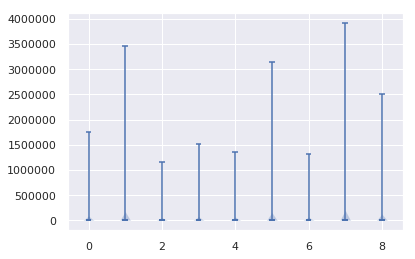

In [22]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]

sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

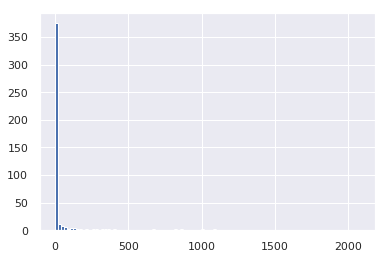

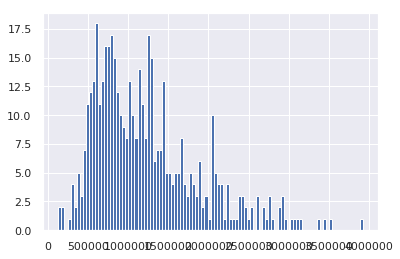

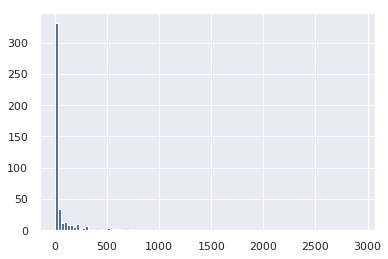

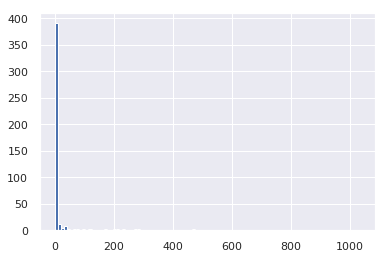

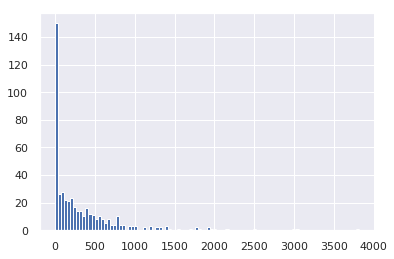

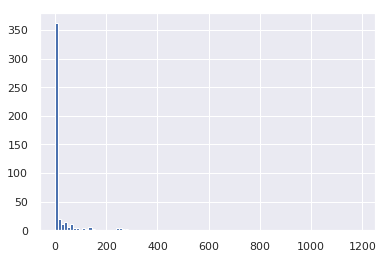

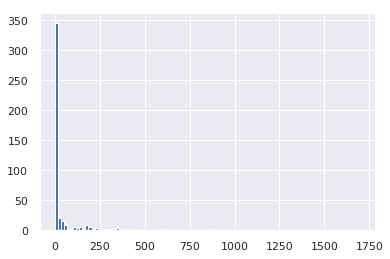

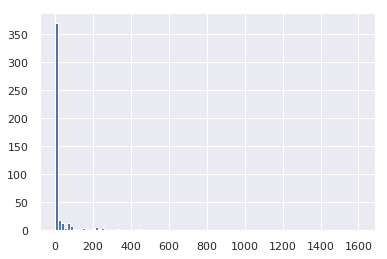

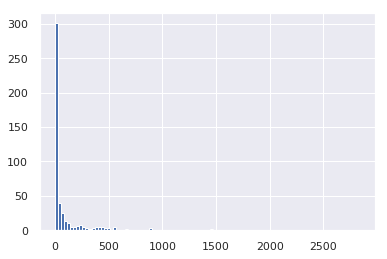

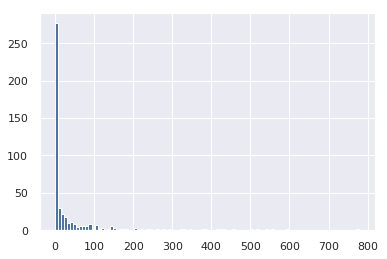

In [4]:
genes = np.random.choice(list(range(D)), p= np.std(data,axis=0)/sum(np.std(data,axis=0)), size=10, replace=False)
for i in range(10):
    plt.hist(data[:,genes[i]], bins=100)
    plt.show()

## Preprocessing

### Transform data

In [3]:
data = np.log2(data+1)

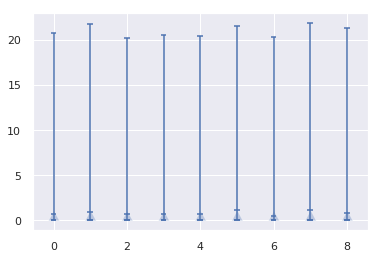

In [5]:
plotdata = [np.concatenate(trans_data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

We remove the genes that are not or barely measured in the dataset to reduce the computational cost.

### Impact of filtering

In [4]:
order = np.argsort(np.std(data, axis=0))
data = data[:,order]

In [ ]:
times = []
outputs = []
lens  = []
dims = []

trans_data = np.log2(data+1)
order = np.argsort(np.std(trans_data, axis=0))
trans_data = trans_data[:,order]
for j in [4,10,25,50,150,250]:
    testdata = trans_data[:j,:]
    model = hierarchical_model()
    start = time.time()
    output = model.fit(testdata, max_depth=1)
    duration = time.time()-start
    lens.append(len(model.cats_per_lvl))
    outputs.append(output)
    times.append(duration)
    dims.append(scores[i])
    print('Analysis with %i dimensions done, took %.2f seconds.'%(j, duration))

Model loaded succesfully from cache.
Model loaded succesfully from cache.
Latent data on top level:


To run all diagnostics call pystan.check_hmc_diagnostics(fit)


In [6]:
scores = []
rang = np.linspace(0,6,500)
stds = np.std(trans_data, axis=0)
for i in rang:
    scores.append(sum(stds>i))

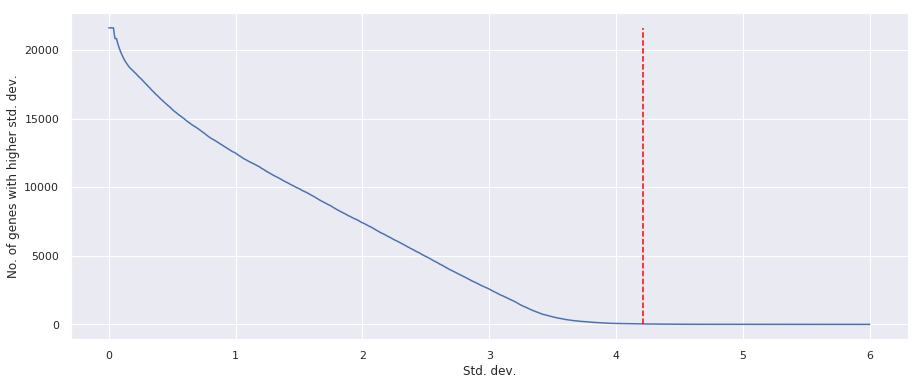

In [7]:
sns.set()
plt.figure(figsize=(15,6))
plt.ylabel('No. of genes with higher std. dev.')
plt.xlabel('Std. dev.')
plt.plot(rang, scores)
plt.plot([rang[350],rang[350]], [0,scores[0]], c = 'red', linestyle='--')
plt.show()

In [24]:
genemask = []
for i in range(len(genetypes)):
    if np.std(trans_data[:,i])>rang[350]:
        genemask.append(True)
    else:
        genemask.append(False)
genemask = np.array(genemask)
print('Using genes with std.dev. of higher than %s'%str(rang[312]))

Using genes with std.dev. of higher than 3.751503006012024


In [25]:
data = trans_data[:,genemask]
genetypes = genetypes[genemask]

In [26]:
np.shape(data)

(465, 36)

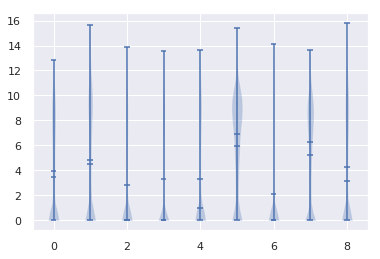

In [48]:
plotdata = [np.concatenate(data[labels==i,:]) for i in range(len(set(labels)))]
sns.set()
plt.violinplot(plotdata, range(len(set(labels))), points=20, widths=0.3,showmeans=True, showextrema=True, showmedians=True)
plt.show()

In [6]:
order = np.argsort(-np.std(data, axis=0))
data = data[:,order]

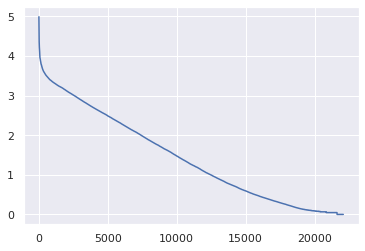

In [7]:
plt.plot(list(range(D)),np.std(data,axis=0))
plt.show()

### Loading/Saving  preprocessed data

In [49]:
# with open('darmanis_prep.pkl', 'wb') as f:
#     pickle.dump([genetypes, data, labels], f)

In [6]:
genetypes, data, labels = pickle.load(open('pickled_data/darmanis_prep.pkl', 'rb'))
N,D = np.shape(data)
print((N,D))

(465, 200)


### Number of clusters is estimated fairly high

In [4]:
est_k(data, k_min=5, k_max = 25, verbose=False, method='bic', refs=3)

(24, {'mu': array([[ 1.22734926,  5.44463001,  6.40725636, ..., 10.10982829,
           1.8651203 ,  6.47500095],
         [ 1.70946463,  0.94643238,  1.2045674 , ...,  0.30270477,
           1.55645666,  4.57164273],
         [ 7.87866439,  6.51020557,  6.62919021, ...,  0.86200857,
           4.70024002,  2.96994676],
         ...,
         [ 4.49521711,  3.87372435,  5.97389386, ...,  1.74620609,
           3.00972176,  2.71537202],
         [ 0.9236604 ,  5.2772481 ,  0.80519119, ...,  0.15205662,
           0.32852721,  0.32852721],
         [ 3.91361967,  3.55362694,  2.30198685, ...,  0.20762051,
           1.01175782,  1.08039181]]),
  'theta': [0.023655913978494623,
   0.060215053763440864,
   0.047311827956989246,
   0.015053763440860216,
   0.030107526881720432,
   0.05591397849462366,
   0.08817204301075268,
   0.023655913978494623,
   0.05806451612903226,
   0.043010752688172046,
   0.021505376344086023,
   0.023655913978494623,
   0.034408602150537634,
   0.00215053763440

### Some clear classes can be observed

In [6]:
n_test = 9
labels_test = KMeans(n_test).fit(data).labels_

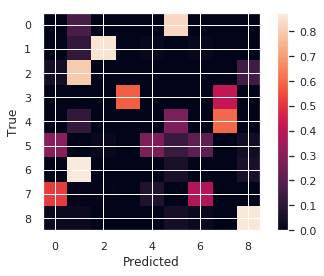

In [7]:
res = np.zeros((9,n_test))
for r in range(9):
    for t in range(n_test):
        res[r,t] = sum(labels[labels_test==t]==r)
    res[r,:] = res[r,:]/sum(res[r,:])
sns.set()
plt.imshow(res, label='Percentage samples')
plt.colorbar()
plt.ylabel('True')
plt.xlabel('Predicted')
plt.show()

In [8]:
adjusted_rand_score(labels, labels_test)

0.503952986286834

## Analysis

Loading model  moppcas_weighted
Model loaded succesfully from cache.
Loading model  ppca_weighted
Model loaded succesfully from cache.
Latent data on top level:


Estimated number of clusters on top-level data: 3 (out of a maximum of) 3


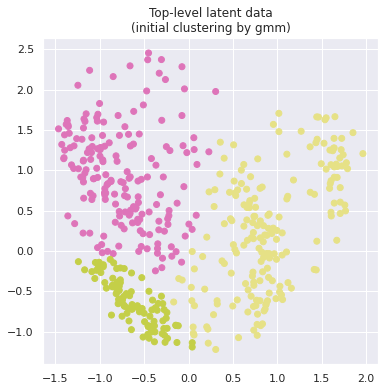

level 1:
Cluster 1:
First guess: cluster 1 contains 3 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 3 clusters.


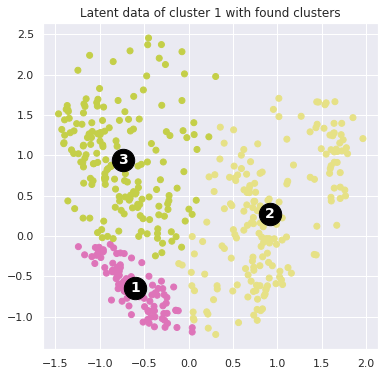

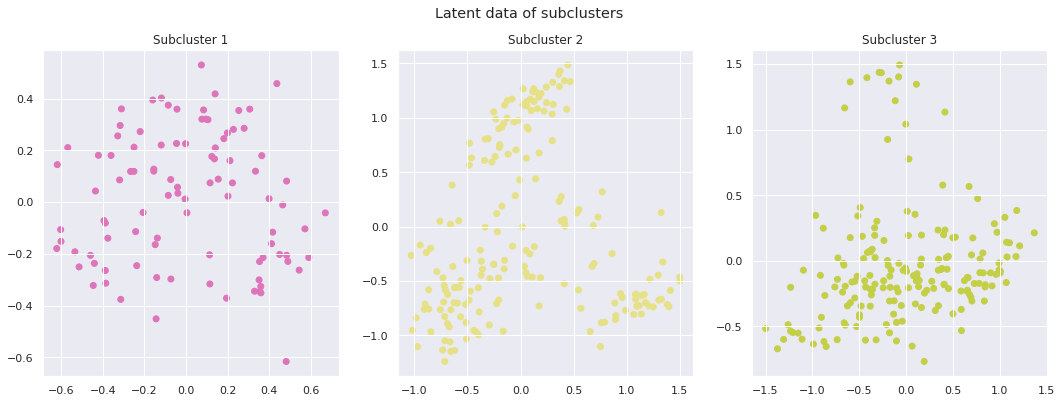

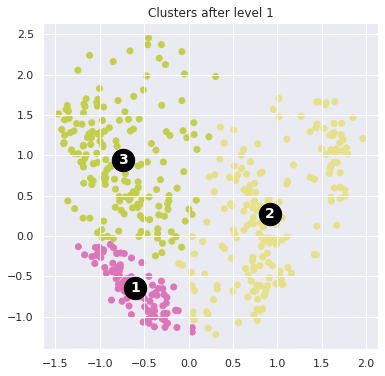

level 2:
Cluster 1:
3  clusters according to AIC,  2  clusters according to BIC.


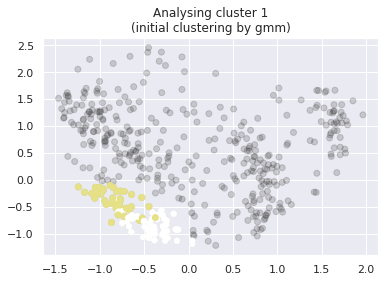

First guess: cluster 1 contains 2 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 2 clusters.


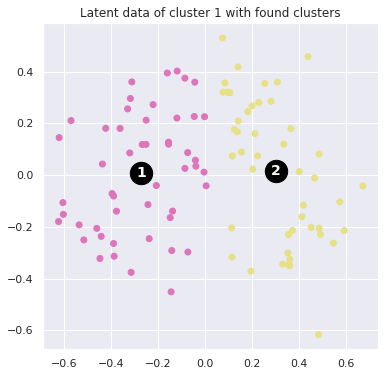

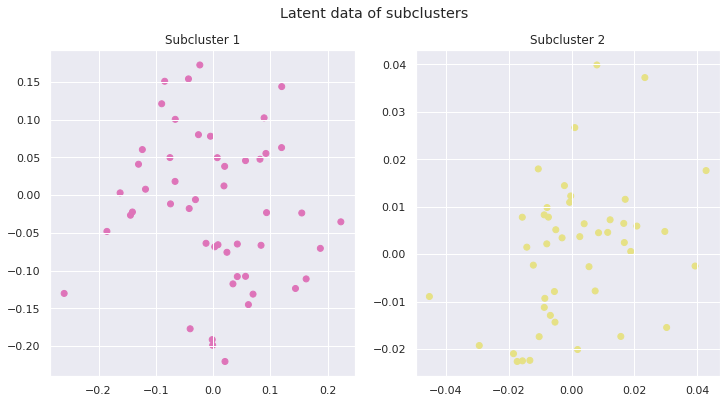

Cluster 2:


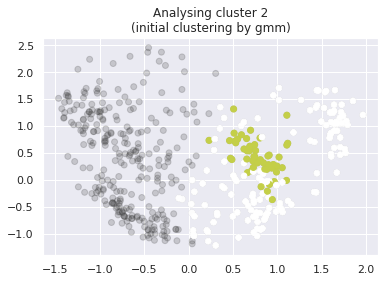

First guess: cluster 2 contains 3 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 2 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 3 clusters.


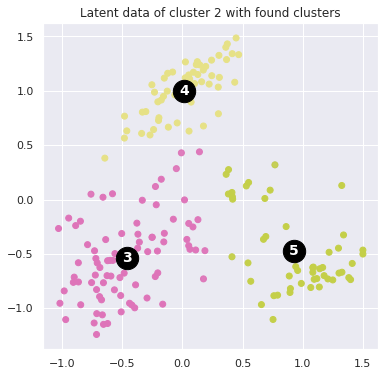

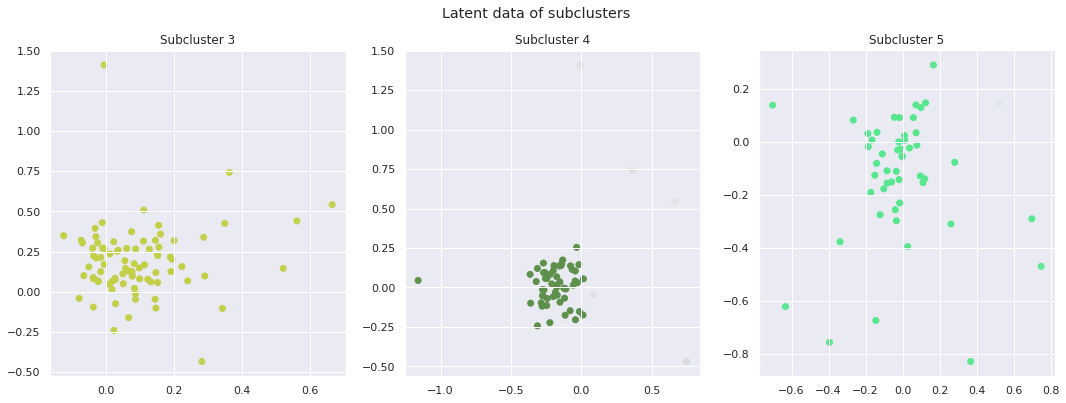

Cluster 3:
3  clusters according to AIC,  2  clusters according to BIC.


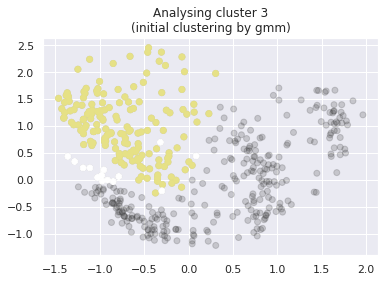

First guess: cluster 3 contains 2 subclusters (out of a maximum of 3)


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 1 clusters.
Trying again for a better fit.


Found MoPPCAs fit with 1 clusters.
MoPPCAS was looking for 2 clusters, but no more subclusters were found.


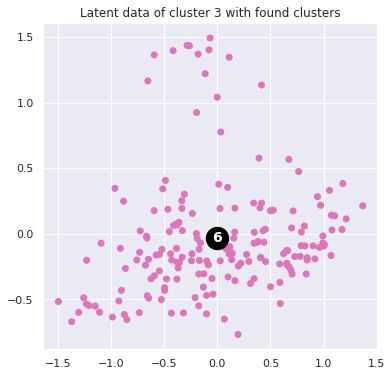

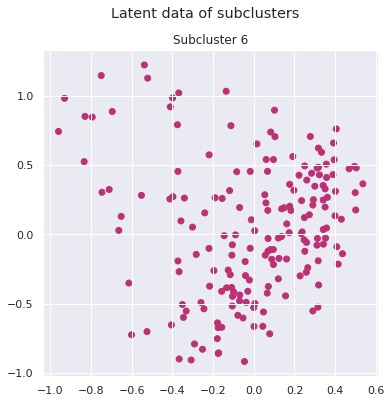

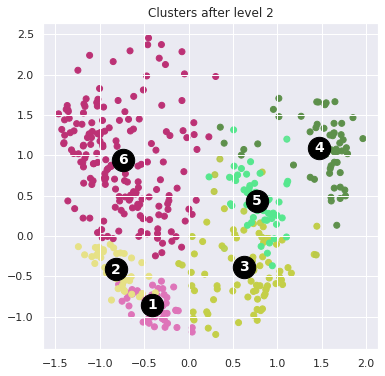

All clusters are fully analyzed!


In [7]:
model = hierarchical_model()
latent, cats_per_lvl, probs = model.fit(data[:,:3000], max_depth=5)

level  0


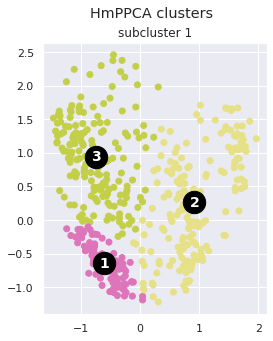

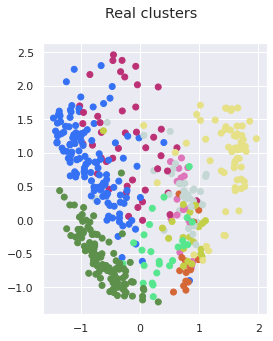

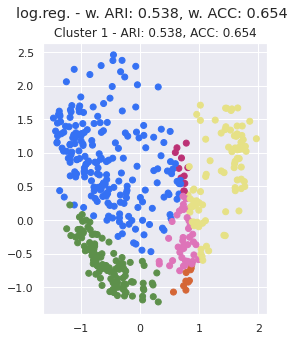

level  1


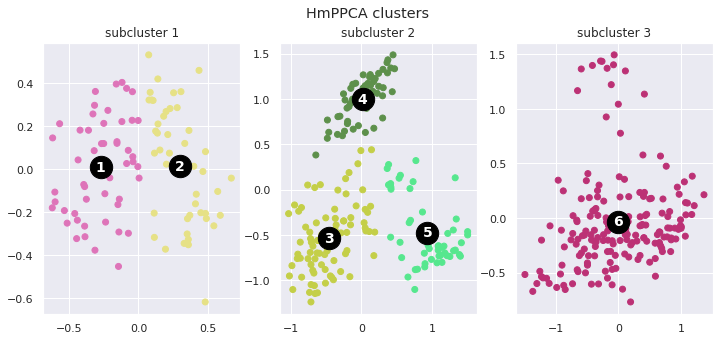

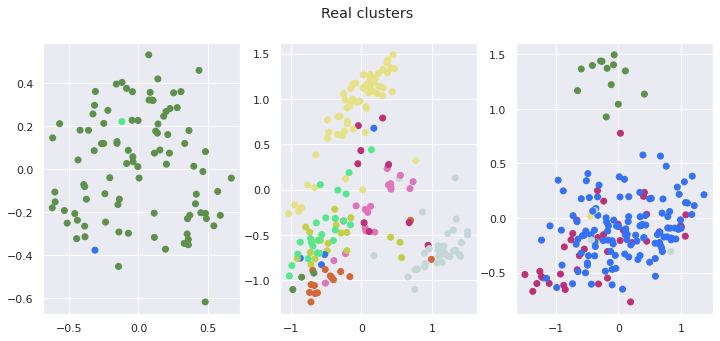

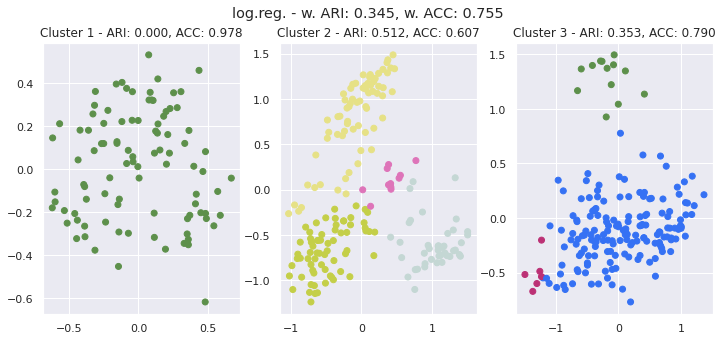

level  2


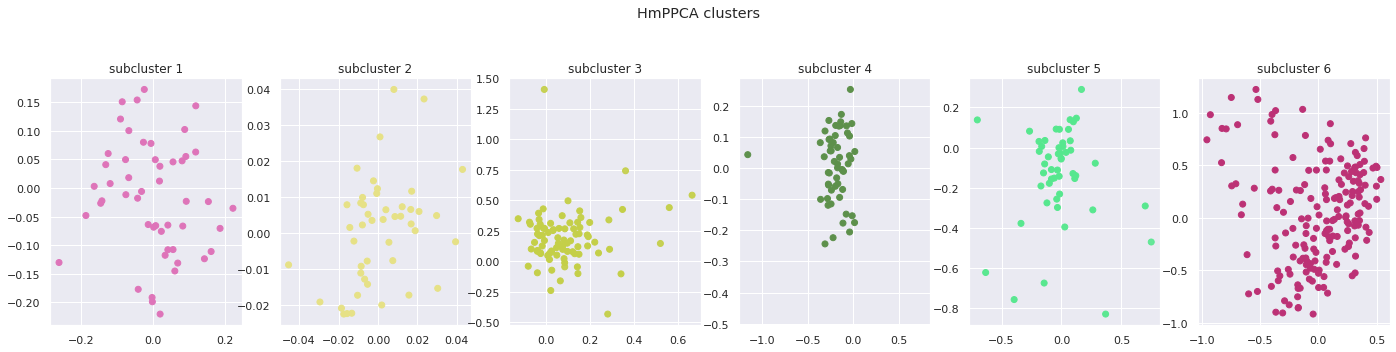

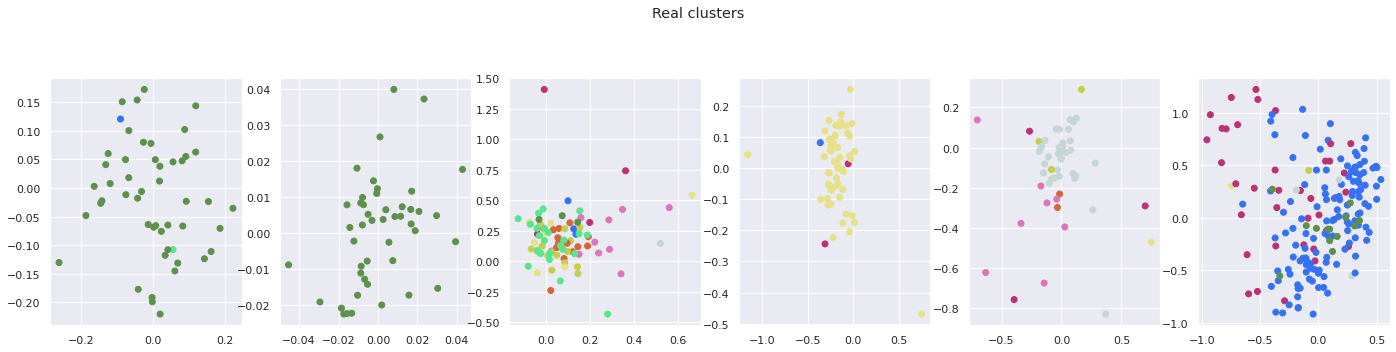

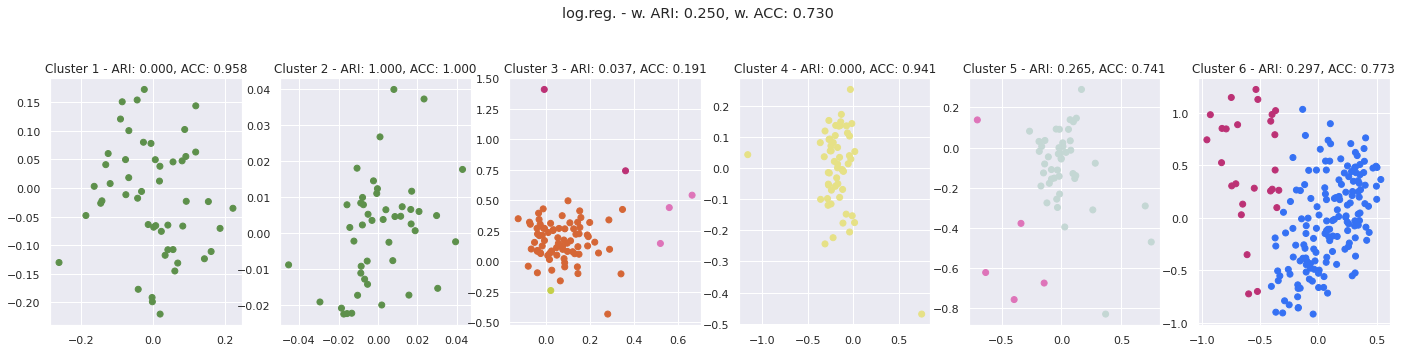

In [8]:
model.visual_score(labels)